********************
 Epoch 0 and iteration 21 
********************
 Epoch 10 and iteration 21 
********************
 Epoch 20 and iteration 21 
********************
 Epoch 30 and iteration 21 
********************
 Epoch 40 and iteration 21 
********************
 Epoch 50 and iteration 21 
********************
 Epoch 60 and iteration 21 
********************
 Epoch 70 and iteration 21 
********************
 Epoch 80 and iteration 21 
********************
 Epoch 90 and iteration 21 


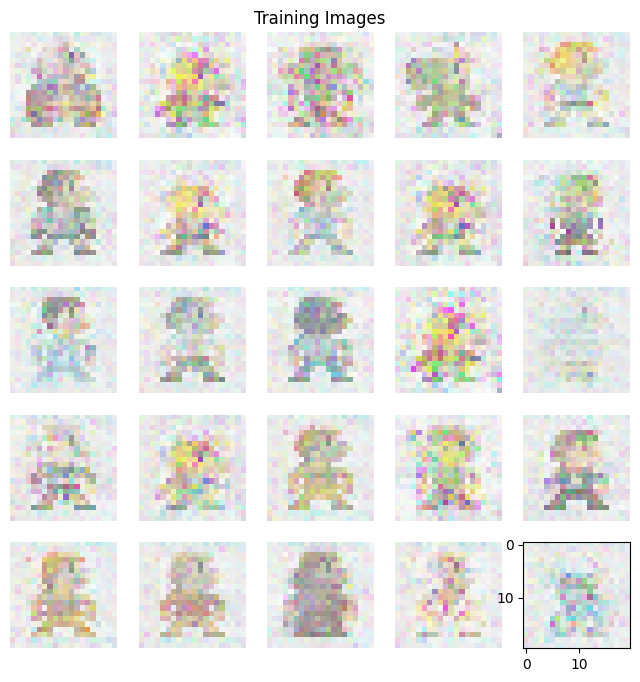

In [2]:
import numpy as np
import torch
from torch import nn
from model import Generator, Discriminator
from dataloader import PixelCharacterDataset, DataLoader
from matplotlib import pyplot as plt
    
def plot_images(imgs, grid_size = 5):
    """
    imgs: vector containing all the numpy images
    grid_size: 2x2 or 5x5 grid containing images
    """
     
    fig = plt.figure(figsize = (8, 8))
    columns = rows = grid_size
    plt.title("Training Images")

    for i in range(1, columns*rows +1):
        plt.axis("off")
        fig.add_subplot(rows, columns, i)
        plt.imshow(imgs[i])
    plt.savefig("training_images.png")

device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

torch.manual_seed(111)

generator = Generator().to(device)
discriminator = Discriminator().to(device)
generator.load_state_dict(torch.load("generator.pth"))
discriminator.load_state_dict(torch.load("discriminator.pth"))
# generator.apply(init_weights)
# discriminator.apply(init_weights)

imgs = np.load('8bit_characters_32x32.npz')
transpose_imgs = np.transpose(
    np.float32(imgs['arr_0']), (0, 3, 1, 2)
)
dset = PixelCharacterDataset(transpose_imgs)

dataloader = DataLoader(dset, batch_size=32, shuffle=True)

lr = 0.001 # learning rate
num_epochs = 100 # number of epochs
def backward_hook(grad):
    print(grad)
loss_function = nn.BCELoss() # Binary Cross Entropy Loss (since we are doing binary classification - whether the data is real or fake)

# We will use Adam optimizer
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

# going over the entire dataset 10 times
for e in range(num_epochs):
     
    # pick each batch b of input images: shape of each batch is (32, 3, 32, 32)
    for i, b in enumerate(dataloader):
 
        ##########################
        ## Update Discriminator ##
        ##########################
 
        # Loss on real images
         
        # clear the gradient
        optimizer_discriminator.zero_grad() # set the gradients to 0 at start of each loop because gradients are accumulated on subsequent backward passes
        # compute the D model output
        yhat = discriminator(b.to(device)).view(-1) # view(-1) reshapes a 4-d tensor of shape (2,1,1,1) to 1-d tensor with 2 values only
        # specify target labels or true labels
        target = torch.ones(len(b), dtype=torch.float, device=device)
        # calculate loss
        loss_real = loss_function(yhat, target)
        # calculate gradients -  or rather accumulation of gradients on loss tensor
        loss_real.backward()
 
        # Loss on fake images
 
        # generate batch of fake images using G
        # Step1: creating noise to be fed as input to G
        noise = torch.randn(len(b), 100, 1, 1, device = device)
        # Step 2: feed noise to G to create a fake img (this will be reused when updating G)
        fake_img = generator(noise) 
 
        # compute D model output on fake images
        yhat = discriminator.cuda()(fake_img.detach()).view(-1) # .cuda() is essential because our input i.e. fake_img is on gpu but model isnt (runtimeError thrown); detach is imp: Basically, only track steps on your generator optimizer when training the generator, NOT the discriminator. 
        # specify target labels
        target = torch.zeros(len(b), dtype=torch.float, device=device)
        # calculate loss
        loss_fake = loss_function(yhat, target)
        # calculate gradients
        loss_fake.backward()
 
        # total error on D
        loss_disc = loss_real + loss_fake
 
        # Update weights of D
        optimizer_discriminator.step()
 
        ##########################
        #### Update Generator ####
        ##########################
 
        # clear gradient
        optimizer_generator.zero_grad()
        # pass fake image through D
        yhat = discriminator.cuda()(fake_img).view(-1)
        # specify target variables - remember G wants D *to think* these are real images so label is 1
        target = torch.ones(len(b), dtype=torch.float, device=device)
        # calculate loss
        loss_gen = loss_function(yhat, target)
        # calculate gradients
        loss_gen.backward()
        # update weights on G
        optimizer_generator.step()
 
 
        ####################################
        #### Plot some Generator images ####
        ####################################
 
        # during every epoch, print images at every 10th iteration.
        if e % 10 == 0 and i == len(dataloader) - 1:
            # convert the fake images from (b_size, 3, 32, 32) to (b_size, 32, 32, 3) for plotting 
            img_plot = np.transpose(fake_img.detach().cpu(), (0,2,3,1)) # .detach().cpu() is imp for copying fake_img tensor to host memory first
            img_plot = (img_plot + 1)/2
            print("********************")
            print(" Epoch %d and iteration %d " % (e, i))
            generated = generator(torch.randn(32, 100, 1, 1, device = device))
            
img_plot = np.transpose(generated.detach().cpu(), (0,2,3,1))
img_plot = (img_plot + 1)/2
plot_images(img_plot, grid_size=5)


torch.save(generator.state_dict(), "generator.pth")
torch.save(discriminator.state_dict(), "discriminator.pth")

